# Gather

This script is tranforming raw netcdf data into tiff files in the following steps:

1. Slicing the netcf into the correct time period needed for the event.
2. Analyzing the data to retrieve the maximum sea waterlevel and rainfall
3. Combining these results with a Digital Elevation Model from that specific area
4. Using the bathtub and hand method to create a tiff file.

In [42]:
import xarray as xr
import pandas as pd
import netCDF4
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pathlib

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

#### User input

In [43]:
# Define the path to the data folder
base_path = "C:/Users/vries_cy/OneDrive - Stichting Deltares/Indonesia case for students"
data_path = "semarang/semarang_forcing/"

data_folder = pathlib.Path(base_path, data_path)


In [44]:
biggest_event_date = "7-4-2012"     #"%d-%m-%Y"
event_windows = 2                   #before afterindays
station = 12932

target_date = datetime.strptime(biggest_event_date, "%d-%m-%Y")
# Define the sliding window
days_before = event_windows
days_after = event_windows
# Calculate the date range
start_date = target_date - timedelta(days=days_before)
end_date = target_date + timedelta(days=days_after)

Creating a map visualization to look at the location

TODO: 
- tooltip
- multiple locations? 
- information about this location

In [45]:
forcing_file = "waterlevel.nc"
waterlevel_data = pathlib.Path(data_folder, forcing_file)

def wgs84_to_web_mercator(lat, lon):
    print(lat, lon)

    k = 6378137
    x = lon * (k * np.pi/180.0)
    y = np.log(np.tan((90 + lat) * np.pi/360.0)) * k

    return x, y

ds = xr.open_dataset(waterlevel_data, engine="netcdf4")
x,y = wgs84_to_web_mercator(ds['station_y_coordinate'].values, ds['station_x_coordinate'].values)

TOOLTIPS = [('Station name', '@station_name')]

p = figure()

l1 = wgs84_to_web_mercator(-7.6, 109.5)
l2 = wgs84_to_web_mercator(-6.2, 111)

# range bounds supplied in web mercator coordinates
p = figure(x_axis_type="mercator", y_axis_type="mercator", tooltips=TOOLTIPS, x_range=(l1[0], l2[0]), y_range=(l1[1], l2[1]))

p.add_tile("CartoDB Positron", retina=True)

p.circle(x, y)
show(p)


[-6.929] [110.347]
-7.6 109.5
-6.2 111


# Coastal flood
The first step is to gain access to the waterlevel data.

TODO: make an assignment with this data. Threshold when it is flooded? 


In [46]:
forcing_file = "waterlevel_gtsm_dailymax.nc"
waterlevel_data = pathlib.Path(data_folder, forcing_file)

ds = xr.open_dataset(waterlevel_data, engine="netcdf4")
water_level_var = ds["waterlevel"]
water_level_df = water_level_var.to_dataframe().reset_index()

sliced_water_level_df = water_level_df[(water_level_df['time'] >= start_date) & (water_level_df['time'] <= end_date) & (water_level_df['stations'] == station)]
max_water_level = sliced_water_level_df['waterlevel'].max()


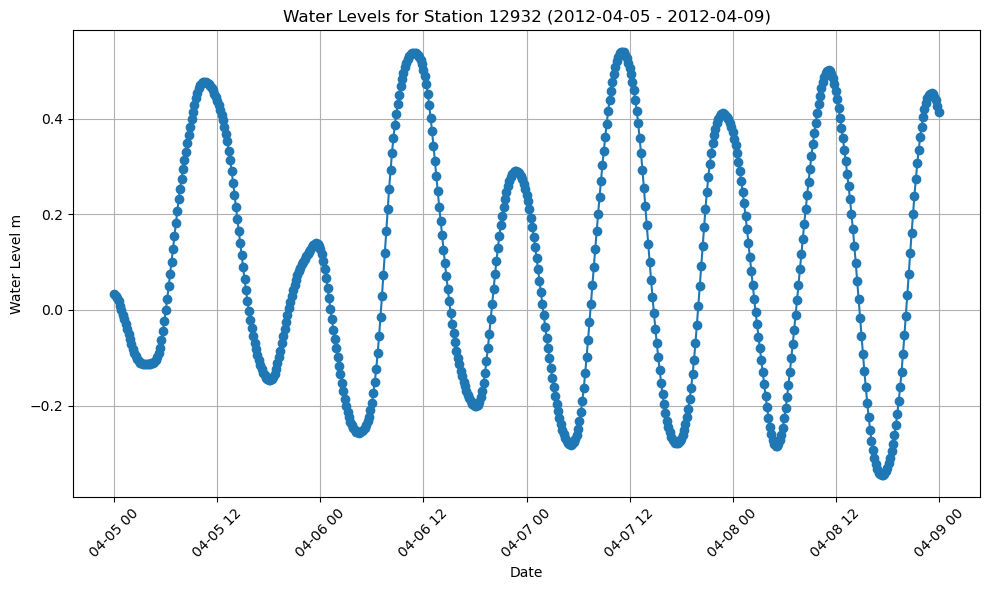

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(sliced_water_level_df['time'], sliced_water_level_df['waterlevel'], marker='o')
plt.title(f'Water Levels for Station {station} ({start_date.date()} - {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Water Level m')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

# Fluvial flood forcing

In [48]:
fluvial_file = "precip_era5.nc"
fluvial_data = pathlib.Path(data_folder, fluvial_file)

ds = xr.open_dataset(fluvial_data, engine="netcdf4")
precipitation_var = ds["precip"]
precipitation_df = precipitation_var.to_dataframe().reset_index()
precipitation_df2 = precipitation_df[precipitation_df["precip"] != 0]
precipitation_df2.dropna(subset=['precip'], inplace=True)
precipitation_df2.to_csv("pdata.csv", sep=';')


sliced_precipitation_df = precipitation_df[(precipitation_df['time'] >= start_date) & (precipitation_df['time'] <= end_date)]
total_precip = np.nanmean(sliced_precipitation_df["precip"])*sliced_precipitation_df.shape[0]/1000


C:\Users\vries_cy\AppData\Local\Temp\ipykernel_44080\2669890748.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  precipitation_df2.dropna(subset=['precip'], inplace=True)


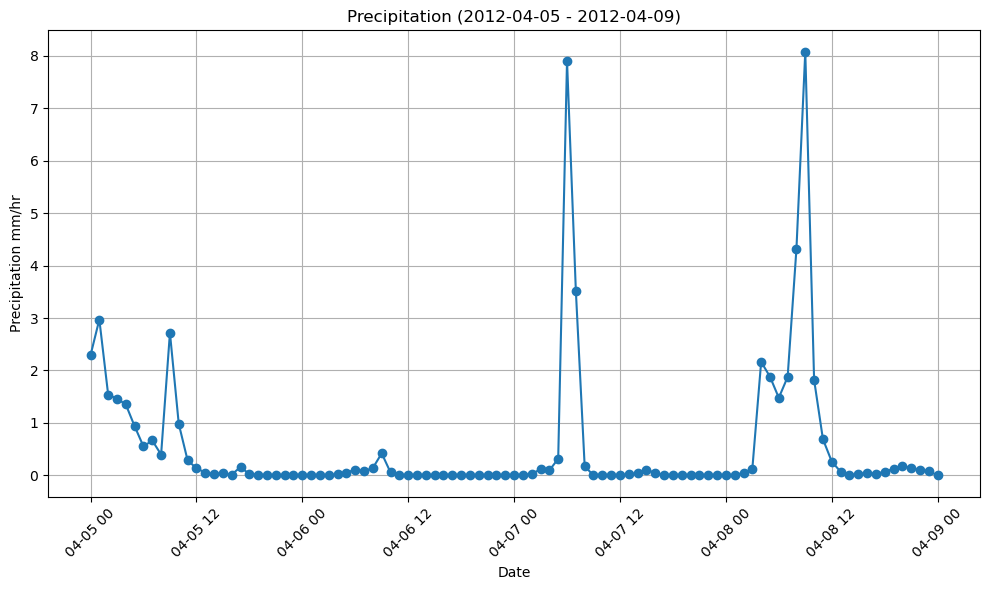

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(sliced_precipitation_df['time'], sliced_precipitation_df['precip'], marker='o')
plt.title(f'Precipitation ({start_date.date()} - {end_date.date()})')
plt.xlabel('Date')
plt.ylabel('Precipitation mm/hr')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


TODO: this code needs cleaning up
This code below is WIP to clean up the code in the cell below this.

In [66]:
# total_precip = sliced_precipitation_df['precip'].sum()
# print(total_precip)
# duration = 999999
# for start_index, start_row in sliced_precipitation_df.iterrows():
#     print(sliced_precipitation_df.loc[start_index])
#     cum_precip = sliced_precipitation_df.loc[start_index:]['precip'].cumsum()
#     end_index = np.where(cum_precip >= total_precip * 0.5 )[0][0]
#     new_dur = end_index
#     if new_dur < duration:
#         best_start_time = pd.Timestamp(start_row['time'])
#         best_end_time = pd.Timestamp(sliced_precipitation_df.loc[start_index + end_index]["time"])

#     print(start_index, end_index)

53.579258
time           2012-04-05 00:00:00
index                            0
y                             -7.0
x                            110.5
spatial_ref                      0
precip                    2.289846
Name: 291552, dtype: object
291552 55
time           2012-04-05 01:00:00
index                            0
y                             -7.0
x                            110.5
spatial_ref                      0
precip                    2.971597
Name: 291553, dtype: object
291553 54
time           2012-04-05 02:00:00
index                            0
y                             -7.0
x                            110.5
spatial_ref                      0
precip                    1.539078
Name: 291554, dtype: object
291554 74
time           2012-04-05 03:00:00
index                            0
y                             -7.0
x                            110.5
spatial_ref                      0
precip                    1.463998
Name: 291555, dtype: object
291555 7

IndexError: index 0 is out of bounds for axis 0 with size 0

In [60]:
total_precip = sliced_precipitation_df['precip'].sum()

sliced_precipitation_df = sliced_precipitation_df.sort_values(by='time')
timestep = sliced_precipitation_df['time'].diff()[1:2].sum()
shortest_duration = timedelta(days=event_windows*2)
best_start_time = None
best_end_time = None

# Iterate through each timestamp as the start time
df_duration = pd.DataFrame()

for i, start_row in sliced_precipitation_df.iterrows():
    current_precip = 0
    current_duration = timedelta()
    
    # Iterate through end times starting from the current start time
    for j, end_row in sliced_precipitation_df.loc[i:].iterrows():
        current_precip += end_row['precip']
        current_duration = end_row['time'] - start_row['time']
        
        if current_precip >= total_precip * 0.5 and current_duration < shortest_duration:
            shortest_duration = current_duration + timestep
            best_start_time = pd.Timestamp(start_row['time'])
            best_end_time = pd.Timestamp(end_row['time'])
            duration = pd.DataFrame(data = (start_row['time'],shortest_duration))
            if df_duration.empty:
                df_duration= duration
            else:
                df_duration = pd.concat([df_duration, duration], axis=1, ignore_index=True)
        
    
    if current_duration >= shortest_duration:
        # No need to continue if the current duration is already longer than the shortest duration found so far
        continue


In [67]:

# Print the result
print(f"Start Time: {best_start_time}")
print(f"End Time: {best_end_time}")
print(f"Shortest Duration: {shortest_duration}")


#PRINT FLUVIAL AND COASTAL FORCING========================================
print(f"Max water level (m) during selected period is {max_water_level}")
print(f"Total precipitation (m) during selected period is {total_precip}")
print(f"Smallest percentage of time when rainfall volume reached 50% is {shortest_duration/timedelta(days=event_windows*2)}")

Start Time: 2012-04-07 07:00:00
End Time: 2012-04-08 16:00:00
Shortest Duration: 1 days 04:00:00
Max water level (m) during selected period is 0.5400000214576721
Total precipitation (m) during selected period is 53.57925796508789
Smallest percentage of time when rainfall volume reached 50% is 0.2916666666666667
